# Log Anomaly Detection with DBSCAN
This notebook detects anomalies in log data using DBSCAN clustering.

In [11]:

import pandas as pd

# Load dataset
file_path = './Linux_2k.log_structured.csv'
df = pd.read_csv(file_path)
df.head()


,LineId,Month,Date,Time,Level,Component,PID,Content,EventId,EventTemplate
0,1,Jun,14,15:16:01,combo,sshd(pam_unix),19939.0,authentication failure; logname= uid=0 euid=0 ...,E16,authentication failure; logname= uid=0 euid=0 ...
1,2,Jun,14,15:16:02,combo,sshd(pam_unix),19937.0,check pass; user unknown,E27,check pass; user unknown
2,3,Jun,14,15:16:02,combo,sshd(pam_unix),19937.0,authentication failure; logname= uid=0 euid=0 ...,E16,authentication failure; logname= uid=0 euid=0 ...
3,4,Jun,15,02:04:59,combo,sshd(pam_unix),20882.0,authentication failure; logname= uid=0 euid=0 ...,E18,authentication failure; logname= uid=0 euid=0 ...
4,5,Jun,15,02:04:59,combo,sshd(pam_unix),20884.0,authentication failure; logname= uid=0 euid=0 ...,E18,authentication failure; logname= uid=0 euid=0 ...


## Preprocessing: Convert Text to Numerical Features

In [12]:

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder, StandardScaler
import numpy as np

# Convert EventId into numerical labels
label_encoder = LabelEncoder()
df["EventId_encoded"] = label_encoder.fit_transform(df["EventId"])

# TF-IDF vectorization of log content
vectorizer = TfidfVectorizer(max_features=500)  
tfidf_matrix = vectorizer.fit_transform(df["Content"])

# Combine encoded EventId and TF-IDF features
X = np.hstack((df["EventId_encoded"].values.reshape(-1, 1), tfidf_matrix.toarray()))

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled.shape


(2000, 501)

## Apply DBSCAN for Anomaly Detection

In [13]:

from sklearn.cluster import DBSCAN

# Apply DBSCAN clustering
dbscan = DBSCAN(eps=1.8, min_samples=5)  
df["Cluster"] = dbscan.fit_predict(X_scaled)

# Count anomalies
num_anomalies = (df["Cluster"] == -1).sum()
num_anomalies


233

## Visualizing Clusters & Anomalies

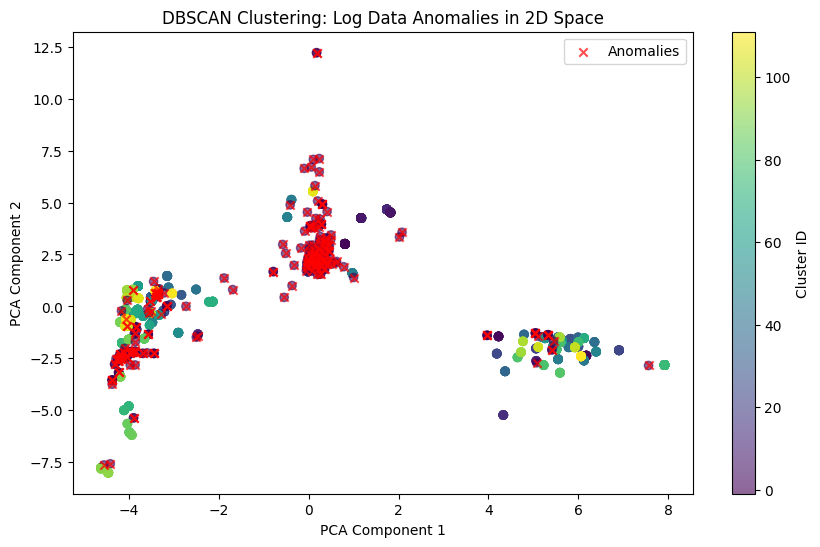

In [14]:

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Reduce to 2D using PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Add PCA coordinates
df["PCA1"] = X_pca[:, 0]
df["PCA2"] = X_pca[:, 1]

# Scatter plot
plt.figure(figsize=(10, 6))
scatter = plt.scatter(df["PCA1"], df["PCA2"], c=df["Cluster"], cmap="viridis", alpha=0.6)
plt.colorbar(scatter, label="Cluster ID")
plt.scatter(df[df["Cluster"] == -1]["PCA1"], df[df["Cluster"] == -1]["PCA2"], 
            color="red", marker="x", label="Anomalies", alpha=0.7)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("DBSCAN Clustering: Log Data Anomalies in 2D Space")
plt.legend()
plt.show()


## Extracting Anomaly Patterns

In [15]:

from collections import Counter
import itertools

# Extract anomalies
anomalies_df = df[df["Cluster"] == -1]

# Count frequent anomalous EventIds
anomalous_event_counts = anomalies_df["EventId"].value_counts().head(10)

# Common keywords in anomaly logs
words = list(itertools.chain(*[content.split() for content in anomalies_df["Content"]]))
common_keywords = Counter(words).most_common(15)

anomalous_event_counts, common_keywords


(EventId
 E29     100
 E18       6
 E16       5
 E36       4
 E47       4
 E89       4
 E19       4
 E20       3
 E21       2
 E116      2
 Name: count, dtype: int64,
 [('at', 103),
  ('from', 102),
  ('2005', 101),
  ('connection', 100),
  ('Jul', 70),
  ('17', 60),
  ('Sun', 57),
  ('207.30.238.8', 46),
  ('(host8.topspot.net)', 46),
  ('()', 38),
  ('Jun', 31),
  ('Wed', 22),
  ('29', 18),
  ('authentication', 17),
  ('failure;', 17)])

## Save Detected Anomalies

In [16]:

# Save anomalies to CSV
anomalies_df[["LineId", "EventId", "Content"]].to_csv("./anomalies_detected.csv", index=False)
"./anomalies_detected.csv"


'./anomalies_detected.csv'

## Analyze Anomalous Events

In [17]:
import re

# Load anomalies file
file_path = "anomalies_detected.csv"
df = pd.read_csv(file_path)

# Count most frequent anomalous EventIds
event_counts = df["EventId"].value_counts().head(10)
print("Most Frequent Anomalous Events:")
print(event_counts)
print("\n" + "="*50 + "\n")

# Extract words from Content column
words = list(itertools.chain(*[content.split() for content in df["Content"]]))
common_keywords = Counter(words).most_common(15)
print("Common Keywords in Anomalies:")
print(common_keywords)
print("\n" + "="*50 + "\n")

# Detect IP addresses in Content
ip_pattern = r'\b(?:[0-9]{1,3}\.){3}[0-9]{1,3}\b'
ip_addresses = list(itertools.chain(*[re.findall(ip_pattern, content) for content in df["Content"]]))
ip_counts = Counter(ip_addresses).most_common(10)
print("Most Frequent IP Addresses in Anomalies:")
print(ip_counts)


Most Frequent Anomalous Events:
EventId
E29     100
E18       6
E16       5
E36       4
E47       4
E89       4
E19       4
E20       3
E21       2
E116      2
Name: count, dtype: int64


Common Keywords in Anomalies:
[('at', 103), ('from', 102), ('2005', 101), ('connection', 100), ('Jul', 70), ('17', 60), ('Sun', 57), ('207.30.238.8', 46), ('(host8.topspot.net)', 46), ('()', 38), ('Jun', 31), ('Wed', 22), ('29', 18), ('authentication', 17), ('failure;', 17)]


Most Frequent IP Addresses in Anomalies:
[('207.30.238.8', 46), ('208.62.55.75', 17), ('211.167.68.59', 6), ('82.252.162.81', 5), ('203.101.45.59', 5), ('059.45.101.203', 5), ('212.0.132.20', 4), ('212.65.68.82', 3), ('24.54.76.216', 2), ('211.72.151.162', 2)]
